In [1]:
import random

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['image.cmap'] = 'coolwarm'

from foregrounds_utils import *
from scipy import stats

from deepmass import lens_data as ld
from deepmass import wiener
from deepmass import cnn_keras as cnn


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
map_size = 256
n_test = int(400)
batch_size = 32
learning_rate = 1e-4

# Load selection of synthesized $Q,U$ maps
## (Fewer examples in this demo than in published full version)
## Rescaling target:

$\sigma_E(DUST) = 1.430 \mu K$

$\sigma_B(DUST) = 0.686 \mu K$

$\sigma_E(CMB) = 3.88 \mu K$

$\sigma_B(CMB) = 0.238 \mu K$

In [3]:
directory_synthesis = './data/synth/'
n_step =5
E_map_std = 1.42964
B_map_std = E_map_std*0.48


# Load synthesized examples and augment
noisy_array = augmented_foreground_generation(directory_synthesis, n_step,
                                              E_map_std, B_map_std, map_size)


1.42964 0.6862272
24
(4800, 256, 256, 2)


In [4]:
clean_array = np.load('./data/cmb/cmb_examples.npy')

# trick to augment number of signal realizations
# (for this demo only to reduce storage of examples)
clean_array = np.concatenate([clean_array,-clean_array])
clean_array = clean_array[:noisy_array.shape[0]]

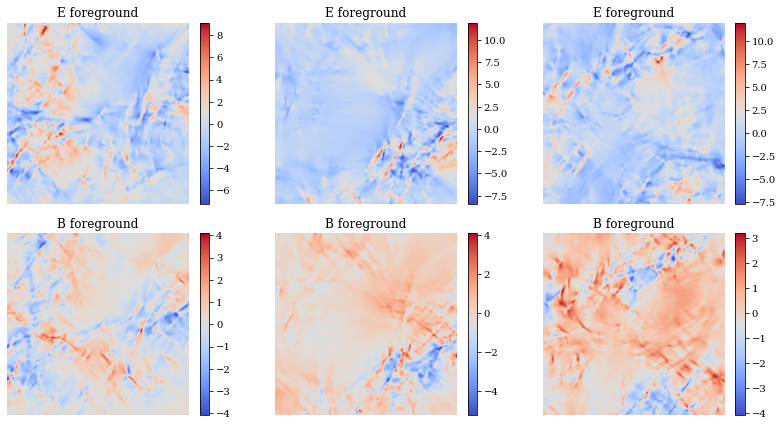

In [5]:
_ = plt.figure(figsize=(12,6))
for i in range(3):
    _ = plt.subplot(2,3,i+1), plt.imshow(noisy_array[i,:,:,0],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('E foreground'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.subplot(2,3,i+4), plt.imshow(noisy_array[i,:,:,1],
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('B foreground'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.tight_layout(True)

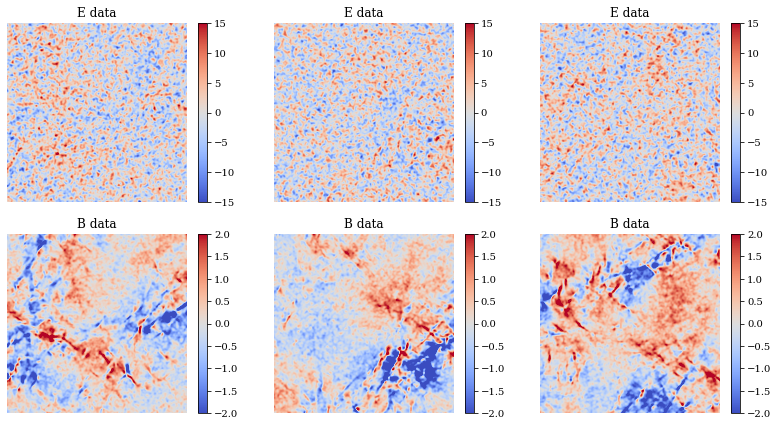

In [6]:
_ = plt.figure(figsize=(12,6))
for i in range(3):
    _ = plt.subplot(2,3,i+1), plt.imshow(noisy_array[i,:,:,0] + clean_array[i,:,:,0], clim=(-15,15),
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('E data'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.subplot(2,3,i+4), plt.imshow(noisy_array[i,:,:,1] + clean_array[i,:,:,1], clim=(-2,2),
                                       interpolation='spline16', cmap = 'coolwarm')
    _ = plt.title('B data'), plt.colorbar(fraction=0.046, pad=0.04)
    _ = plt.axis('off')
    _ = plt.tight_layout(True)

## CNN rescaling for network dynamic range

In [7]:
cnn_rescale_E = 57.
cnn_rescale_B = 10.

In [8]:
# Draw from amplitude prior distribution (add scatter)

for i in range(noisy_array.shape[0]):
    if i%2000==0: print(i)
    noisy_array[i,:,:,0] = noisy_array[i,:,:,0]*np.random.normal(1.,0.044/0.172)
    noisy_array[i,:,:,1] = noisy_array[i,:,:,1]*np.random.normal(1.,0.044/0.172)

noisy_array = noisy_array + clean_array

noisy_array[:,:,:,0] = noisy_array[:,:,:,0]/cnn_rescale_E
clean_array[:,:,:,0] = clean_array[:,:,:,0]/cnn_rescale_E
noisy_array[:,:,:,1] = noisy_array[:,:,:,1]/cnn_rescale_B
clean_array[:,:,:,1] = clean_array[:,:,:,1]/cnn_rescale_B

noisy_array = np.clip(noisy_array, -0.5, 0.5)
clean_array = np.clip(clean_array, -0.5, 0.5)

test_array_noisy = noisy_array[:n_test]
test_array_clean = clean_array[:n_test]
gc.collect()

noisy_array = noisy_array[n_test:]
clean_array = clean_array[n_test:]
gc.collect()

0
2000
4000


0

# Train Moment Network 

## Posterior mean

In [9]:
train_gen = cnn.BatchGenerator(noisy_array+0.5,
                               np.expand_dims(np.atleast_3d(clean_array[:,:,:,1]), axis=3)+0.5,
                               gen_batch_size=batch_size)
test_gen = cnn.BatchGenerator(test_array_noisy+0.5,
                               np.expand_dims(np.atleast_3d(test_array_clean[:,:,:,1]), axis=3)+0.5,
                              gen_batch_size=batch_size)

cnn_instance = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate, channels=[2,1])
cnn_model = cnn_instance.model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 304         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
138/138 [==============================] - 11s 80ms/step - loss: 0.0082 - val_loss: 9.3606e-04
Epoch 2/40
138/138 [==============================] - 10s 73ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/40
138/138 [==============================] - 10s 72ms/step - loss: 0.0012 - val_loss: 8.0577e-04
Epoch 4/40
138/138 [==============================] - 10s 73ms/step - loss: 8.9818e-04 - val_loss: 7.2003e-04
Epoch 5/40
138/138 [==============================] - 10s 72ms/step - loss: 7.5167e-04 - val_loss: 6.5985e-04
Epoch 6/40
138/138 [==============================] - 10s 73ms/step - loss: 6.6250e-04 - val_loss: 6.1747e-04
Epoch 7/40
138/138 [==============================] - 10s 73ms/step - loss: 5.9609e-04 - val_loss: 5.6678e-04
Epoch 8/40
138/138 [==============================] - 10s 73ms/step - loss: 5.4968e-04 - val_loss: 5.4234e-04
Epoch 9/40
138/138 [==============================] - 10s 73

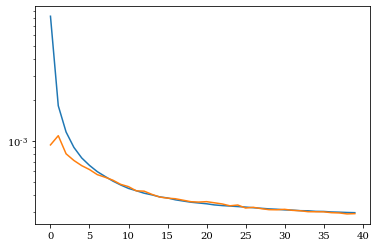

In [10]:
history = cnn_model.fit_generator(generator=train_gen,
                         epochs=40,
                         steps_per_epoch=np.ceil(noisy_array.shape[0] / int(batch_size)),
                         validation_data=test_gen,
                         validation_steps=np.ceil(test_array_noisy.shape[0] / int(batch_size)), verbose=True)

gc.collect()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

In [11]:
cnn_model.save('./models/demo_mean')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./models/demo_mean/assets


In [12]:
test_output = cnn_model.predict(test_array_noisy[:5,:,:]+0.5)

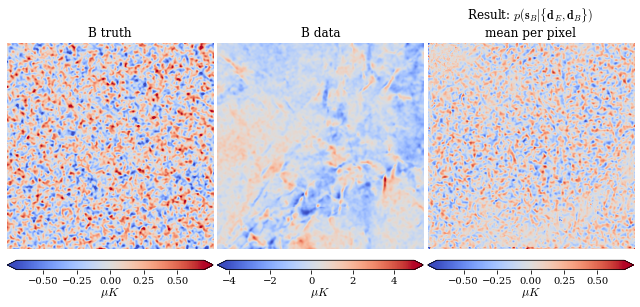

In [20]:
fig = plt.figure(figsize=(9.,4.5))
_ = plt.subplot(1,3,1)
_ = plt.imshow(clean_array[i,:,:,1]*cnn_rescale_B, clim=(-0.07*cnn_rescale_B,0.07*cnn_rescale_B),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('B truth')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='both')  
cb.ax.set_title(r'$\mu K$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')
_ = plt.subplot(1,3,2), plt.imshow(noisy_array[i,:,:,1]*cnn_rescale_B,
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('B data')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='both')    
cb.ax.set_title(r'$\mu K$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')
_ = plt.subplot(1,3,3), plt.imshow((test_output[i,:,:,0]-0.5)*cnn_rescale_B, clim=(-0.07*cnn_rescale_B,0.07*cnn_rescale_B),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Result: ' + r'$p(\mathbf{s}_B | \{\mathbf{d}_E, \mathbf{d}_B\})$' + '\nmean per pixel')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='both')  
cb.ax.set_title(r'$\mu K$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0)

## Posterior variance

In [14]:
predict_batch = 256
n_predict_batches = np.ceil(noisy_array.shape[0]/predict_batch).astype(int)

target_var = np.vstack([cnn_model.predict(0.5+noisy_array[i*predict_batch:(i+1)*predict_batch]) 
                        for i in range(n_predict_batches)])

target_var = 100*(target_var - np.expand_dims(np.atleast_3d(clean_array[:,:,:,1]), axis=3) - 0.5)**2.

train_gen_var = cnn.BatchGenerator(noisy_array[n_test:]+0.5,
                                   target_var[n_test:],
                                   gen_batch_size=batch_size)
test_gen_var = cnn.BatchGenerator(noisy_array[:n_test]+0.5,
                                  target_var[:n_test],
                                  gen_batch_size=batch_size)

cnn_instance_var = cnn.UnetlikeBaseline(map_size=map_size, learning_rate=learning_rate, channels=[2,1])
cnn_model_var = cnn_instance_var.model()

print('Train variance', flush=True)


history_var = cnn_model_var.fit_generator(generator=train_gen_var,
                         epochs=10,
                         steps_per_epoch=np.ceil(noisy_array[n_test:].shape[0] / int(batch_size)),
                         validation_data=test_gen_var,
                         validation_steps=np.ceil(noisy_array[:n_test].shape[0] / int(batch_size)))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 2) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 256, 16) 304         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 256, 256, 16) 64          conv2d_10[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_4 (AveragePoo (None, 128, 128, 16) 0           batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [15]:
cnn_model_var.save('./models/demo_var')

INFO:tensorflow:Assets written to: ./models/demo_var/assets


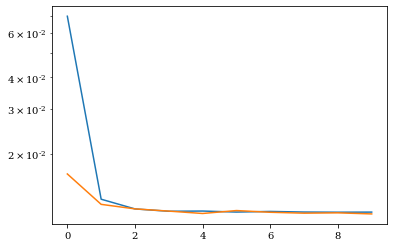

In [16]:
plt.plot(history_var.history['loss'])
plt.plot(history_var.history['val_loss'])
plt.yscale('log')

# Validation with independent simulation
## Remember this is a demo with reduced training!

In [17]:
validation_data = np.load('./data/sim/validation_sim.npy')
clean_validation_data = validation_data[1]
validation_data = validation_data[0]

In [18]:
mean_test = cnn_model(validation_data+0.5)
var_test = cnn_model_var(validation_data+0.5)/100.

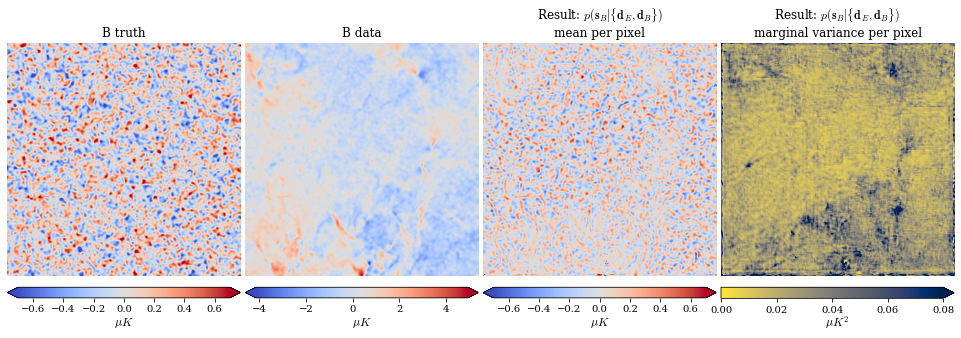

In [23]:
fig = plt.figure(figsize=(13.5,4.5))
i=0
_ = plt.subplot(1,4,1)
_ = plt.imshow(clean_validation_data[i,:,:,1]*cnn_rescale_B, clim=(-0.07*cnn_rescale_B,0.07*cnn_rescale_B),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('B truth')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='both')  
cb.ax.set_title(r'$\mu K$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')
_ = plt.subplot(1,4,2), plt.imshow(validation_data[i,:,:,1]*cnn_rescale_B,
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('B data')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='both')    
cb.ax.set_title(r'$\mu K$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')
_ = plt.subplot(1,4,3), plt.imshow((mean_test[i,:,:,0]-0.5)*cnn_rescale_B, clim=(-0.07*cnn_rescale_B,0.07*cnn_rescale_B),
                                   interpolation='spline16', cmap = 'coolwarm')
_ = plt.title('Result: ' + r'$p(\mathbf{s}_B | \{\mathbf{d}_E, \mathbf{d}_B\})$' + '\nmean per pixel')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='both')  
cb.ax.set_title(r'$\mu K$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')
_ = plt.subplot(1,4,4), plt.imshow((var_test[i,:,:,0])*(cnn_rescale_B**2), clim=(0.0,0.0008*(cnn_rescale_B**2)),
                                   interpolation='spline16', cmap = 'cividis_r')
_ = plt.title('Result: ' + r'$p(\mathbf{s}_B | \{\mathbf{d}_E, \mathbf{d}_B\})$' + '\nmarginal variance per pixel')
cb = plt.colorbar(fraction=0.046, pad=0.04, orientation="horizontal", extend='max')    
cb.ax.set_title(r'$\mu K^2$',fontsize=12,y=-1.3,pad=-14)
_ = plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(wspace=0.02, hspace=0)

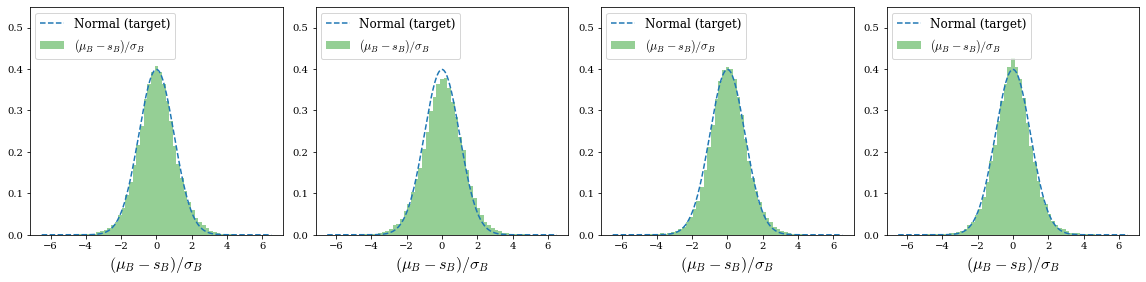

In [19]:
x=np.linspace(-6.5,6.5,512)
plt.figure(figsize=(16,4.))
for i in range(4):
    plt.subplot(1,4,i+1)
    samples_normal_temp = (mean_test[i,:,:,0]-0.5-clean_validation_data[i,:,:,1])/np.sqrt(var_test[i,:,:,0])
    samples_normal_temp = np.array(samples_normal_temp).flatten()
    _ = plt.hist(samples_normal_temp, bins=np.linspace(-6.5,6.5,64), color='C2',
                 density=True, alpha=0.5,label=r'$( \mu_B - s_B ) / \sigma_B$')
    _ = plt.plot(x, stats.norm.pdf(x, 0, 1),'--', label='Normal (target)')
    _ = plt.legend(fontsize=12., loc=(0.02,0.77)), plt.ylim(0,0.55)
    _ = plt.tight_layout(True)
    _ = plt.xlabel(r'$( \mu_B - s_B ) / \sigma_B$',fontsize=16.)